In [205]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import json

In [206]:
#データの前処理
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 画像サイズを64x64にリサイズ
    transforms.ToTensor(),        # テンソルに変換
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]に正規化
])

In [207]:
# 自作の画像データセットをロード
dataset = datasets.ImageFolder(root='./Original', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [208]:
data = [
    "----------------------------------------------------------------------",
    "----------------------------------------------------------------------",
    "----------------------------------------------------------------------",
    "----------------------------------------------------------------------",
    "----------------------------------------------------------------------",
    "--------------------H-------------------------------------------------",
    "--------------------H-------------------------------------------------",
    "--------------------H-------------------------------------------------",
    "--------------------H-------------------------------------------------",
    "--------------------H------------------------------------------------H",
    "--------------------H------------------------------------------------H",
    "--------------------HH------------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH",
    "---------------------SSSSSSSSSSSSSS----SSSSSSSSSSSSSSS----HHH--------H",
    "-----------------------SSSSSSSSSS---------SSSSSSSSSS-------HH--------H",
    "-------------------------SSSSSS----------------------------H---------H",
    "---------------------------------------------------------------------H",
    "---------------------------------------------------------------------H",
    "----------------------------------------------SSSSS------------------H",
    "HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH",
]

In [224]:
# VAEの定義
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent Space
        # ここで特徴マップのサイズを計算して、それに基づいてfc_muとfc_logvarの入力サイズを設定する
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 70, 19)
            encoder_output_size = self.encoder(dummy_input).shape[1]
        self.fc_mu = nn.Linear(encoder_output_size, latent_dim)
        self.fc_logvar = nn.Linear(encoder_output_size, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 5 * 2),
            nn.ReLU(),
            nn.Unflatten(1, (256, 5, 2)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


In [225]:
# VAEの学習
def train_vae():
    num_epochs = 50
    latent_dim = 64
    target_color = torch.tensor([255, 0, 0], dtype=torch.float) / 255.0  # 目標の色を指定（例：赤色）
    vae = VAE(latent_dim)
    
    loss_fn = CustomLoss(target_color)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.to(device)

    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        for batch, _ in dataloader:
            batch = batch.to(device)

            optimizer.zero_grad()
            reconstructed_data, mu, log_var = vae(batch)

            # Reconstruction Loss
            reconstruction_loss = loss_fn(reconstructed_data, batch)

            # KL Divergence Loss
            kl_divergence_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total Loss
            total_loss += reconstruction_loss + kl_divergence_loss
            (reconstruction_loss + kl_divergence_loss).backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {total_loss.item() / len(dataloader)}")

    return vae

In [226]:
# 自動生成
def generate_images(vae, num_images=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.to(device)
    vae.eval()

    with torch.no_grad():
        z = torch.randn(num_images, vae.latent_dim).to(device)
        generated_data = vae.decode(z)
        generated_images = generated_data.cpu().numpy()

    for i in range(num_images):
        image = Image.fromarray(((generated_images[i] + 1) * 0.5 * 255).astype('uint8').transpose(1, 2, 0))
        image.show()


In [215]:
# VAEの学習と自動生成
latent_dim = 64
vae = VAE(latent_dim)

trained_vae = train_vae()
generate_images(trained_vae)

Epoch [1/50], Total Loss: 0.38237079977989197
Epoch [2/50], Total Loss: 0.3562902808189392
Epoch [3/50], Total Loss: 0.16767702996730804
Epoch [4/50], Total Loss: 0.10223034024238586
Epoch [5/50], Total Loss: 0.039765726774930954
Epoch [6/50], Total Loss: 0.023492969572544098
Epoch [7/50], Total Loss: 0.0030711451545357704
Epoch [8/50], Total Loss: 0.023017585277557373
Epoch [9/50], Total Loss: 0.021263157948851585
Epoch [10/50], Total Loss: 0.11217538267374039
Epoch [11/50], Total Loss: 0.054427143186330795
Epoch [12/50], Total Loss: 0.04277368262410164
Epoch [13/50], Total Loss: 0.01896623894572258
Epoch [14/50], Total Loss: 0.023510361090302467
Epoch [15/50], Total Loss: 0.015646256506443024
Epoch [16/50], Total Loss: 0.012746486812829971
Epoch [17/50], Total Loss: 0.020282888785004616
Epoch [18/50], Total Loss: 0.0019073272123932838
Epoch [19/50], Total Loss: 0.0033903757575899363
Epoch [20/50], Total Loss: 0.007609104737639427
Epoch [21/50], Total Loss: 0.008261746726930141
Epoch 

ValueError: axes don't match array

In [227]:
class CustomLoss(nn.Module):
    def __init__(self, target_color):
        super(CustomLoss, self).__init__()
        self.target_color = target_color  # 目標の色を指定

    def forward(self, output, target):
        # output: モデルの出力（生成画像）
        # target: 目標の色

        # ピクセルごとに目標の色との差を計算（MSE損失）
        loss = nn.MSELoss()
        return loss(output, self.target_color)


In [228]:
def generate_images(vae, num_images=5):
    # VAEから画像を生成
    with torch.no_grad():
        z = torch.randn(num_images, latent_size).to(device)
        generated_data = vae.decode(z).view(-1, 3, image_size, image_size)

    # generated_dataの値を（-1, 1）の範囲から（0, 1）にスケーリングしてuint8に変換し、画像として表示
    generated_images = ((generated_data + 1) * 0.5).clamp(0, 1).cpu().numpy()

    for i in range(num_images):
        # generated_imagesの形状が（チャンネル数、高さ、幅）の順序であることを確認してから、Image.fromarray()を呼び出す
        image = Image.fromarray((generated_images[i] * 255).astype('uint8').transpose(1, 2, 0))
        image.show()

In [229]:
#TODO

In [230]:
def generate_images(vae, num_images):
    vae.eval()  # モデルを評価モードに設定

    # ランダムな潜在変数zを生成
    latent_dim = vae.latent_dim
    z = torch.randn(num_images, latent_dim).to(vae.device)

    # 生成器を使って画像を生成
    generated_data = vae.decode(z)

    # 画像データを0〜255の範囲に変換
    generated_images = ((generated_data + 1) * 0.5 * 255).cpu().numpy().astype('uint8')

    # 画像を表示
    for i in range(num_images):
        image = Image.fromarray(generated_images[i].transpose(1, 2, 0))  # `transpose`を削除
        image.show()

latent_dim = 64
vae = VAE(latent_dim)
trained_vae = train_vae()
generate_images(trained_vae, num_images=5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x4096 and 1024x64)

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt
from PIL import Image

In [32]:
# ハイパーパラメータ
original_dim = 70 * 19 * 3  # 70x19のRGB画像の場合は3チャンネル
latent_dim = 2
intermediate_dim = 256
batch_size = 100
epochs = 50

In [33]:
# PNGファイルの読み込みと前処理
def load_and_preprocess_images(file_paths):
    images = []
    for path in file_paths:
        img = Image.open(path)
        img = img.resize((70, 19))  # 70x19にリサイズ
        img = np.array(img)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

In [34]:
# 画像ファイルのパスを指定
image_files = ["./Original/class1/grid_image.png", "./Original/class1/grid_image3.png"]

In [35]:
# 画像データの読み込みと前処理
x_train = load_and_preprocess_images(image_files)

In [36]:
# サンプリング関数
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [37]:
# VAEのエンコーダ部分
input_img = Input(shape=(original_dim,))
hidden_enc = Dense(intermediate_dim, activation='relu')(input_img)
z_mean = Dense(latent_dim)(hidden_enc)
z_log_var = Dense(latent_dim)(hidden_enc)


TypeError: _variable_v1_call() got an unexpected keyword argument 'experimental_enable_variable_lifting'

In [ ]:
# 潜在空間のサンプリング関数
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [30]:
# VAEのデコーダ部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
hidden_dec = decoder_h(z)
output_img = decoder_mean(hidden_dec)

NameError: name 'z' is not defined

In [ ]:
# VAEモデルの構築
vae = Model(input_img, output_img)

# VAEの損失関数
reconstruction_loss = mse(input_img, output_img)
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
vae_loss = reconstruction_loss + kl_loss

In [24]:
# VAEのコンパイル
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# VAEのトレーニング
vae.fit(x_train, epochs=epochs, batch_size=batch_size)

2.12.0


ERROR: Could not find a version that satisfies the requirement tensorflow==1.5.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==1.5.0


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [27]:
# ハイパーパラメータ
original_dim = 70 * 19 * 3  # 70x19のRGB画像の場合は3チャンネル
latent_dim = 2
intermediate_dim = 256
batch_size = 100
epochs = 50

In [28]:
# 画像ファイルの読み込みと前処理
def load_and_preprocess_images(file_paths):
    images = []
    for path in file_paths:
        img = Image.open(path)
        img = img.resize((70, 19))  # 70x19にリサイズ
        img = np.array(img)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

In [26]:
# VAEの実装
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc21 = nn.Linear(256, latent_dim)
        self.fc22 = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt
from PIL import Image

# ハイパーパラメータ
original_dim = 70 * 19 * 3  # 70x19のRGB画像の場合は3チャンネル
latent_dim = 2
intermediate_dim = 256
batch_size = 100
epochs = 50

# PNGファイルの読み込みと前処理
def load_and_preprocess_images(file_paths):
    images = []
    for path in file_paths:
        img = Image.open(path)
        img = img.resize((70, 19))  # 70x19にリサイズ
        img = np.array(img)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

# 画像ファイルのパスを指定
image_files = ["./Original/class1/grid_image.png", "./Original/class1/grid_image3.png"]

# 画像データの読み込みと前処理
x_train = load_and_preprocess_images(image_files)

# VAEのエンコーダ部分
input_img = Input(shape=(original_dim,))
hidden_enc = Dense(intermediate_dim, activation='relu')(input_img)
z_mean = Dense(latent_dim)(hidden_enc)
z_log_var = Dense(latent_dim)(hidden_enc)

# 潜在空間のサンプリング関数
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# VAEのデコーダ部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
hidden_dec = decoder_h(z)
output_img = decoder_mean(hidden_dec)

# VAEモデルの構築
vae = Model(input_img, output_img)

# VAEの損失関数
reconstruction_loss = mse(input_img, output_img)
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
vae_loss = reconstruction_loss + kl_loss

# VAEのコンパイル
vae.add_loss(vae_loss)

optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer=optimizer)

# VAEのトレーニング
vae.fit(x_train, epochs=epochs, batch_size=batch_size)


TypeError: _variable_v1_call() got an unexpected keyword argument 'experimental_enable_variable_lifting'

In [85]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 再現性のためにランダムシードを設定する
manualSeed = 999
#manualSeed = random.randint（1、10000）＃新しい結果が必要な場合に使用
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [90]:
# データセットのルートディレクトリ
dataroot = "./Original/"

# データローダーのワーカー数
workers = 2

# トレーニングのバッチサイズ
batch_size = 128

# トレーニング画像の空間サイズ。
# すべての画像はトランスフォーマーを使用してこのサイズに変更されます。
image_size = 1330

# トレーニング画像のチャネル数。カラー画像の場合は「3」 
nc = 3

# 潜在ベクトル z のサイズ（つまり、ジェネレータ入力のサイズ）
nz = 100

# 生成器の feature map のサイズ
ngf = 64

# 識別器の feature map のサイズ
ndf = 64

# エポック数
num_epochs = 5

# 学習率
lr = 0.0002

# Adam オプティマイザのBeta1ハイパーパラメータ
beta1 = 0.5

# 使用可能なGPUの数。0の場合、CPUモードで実行されます
ngpu = 1


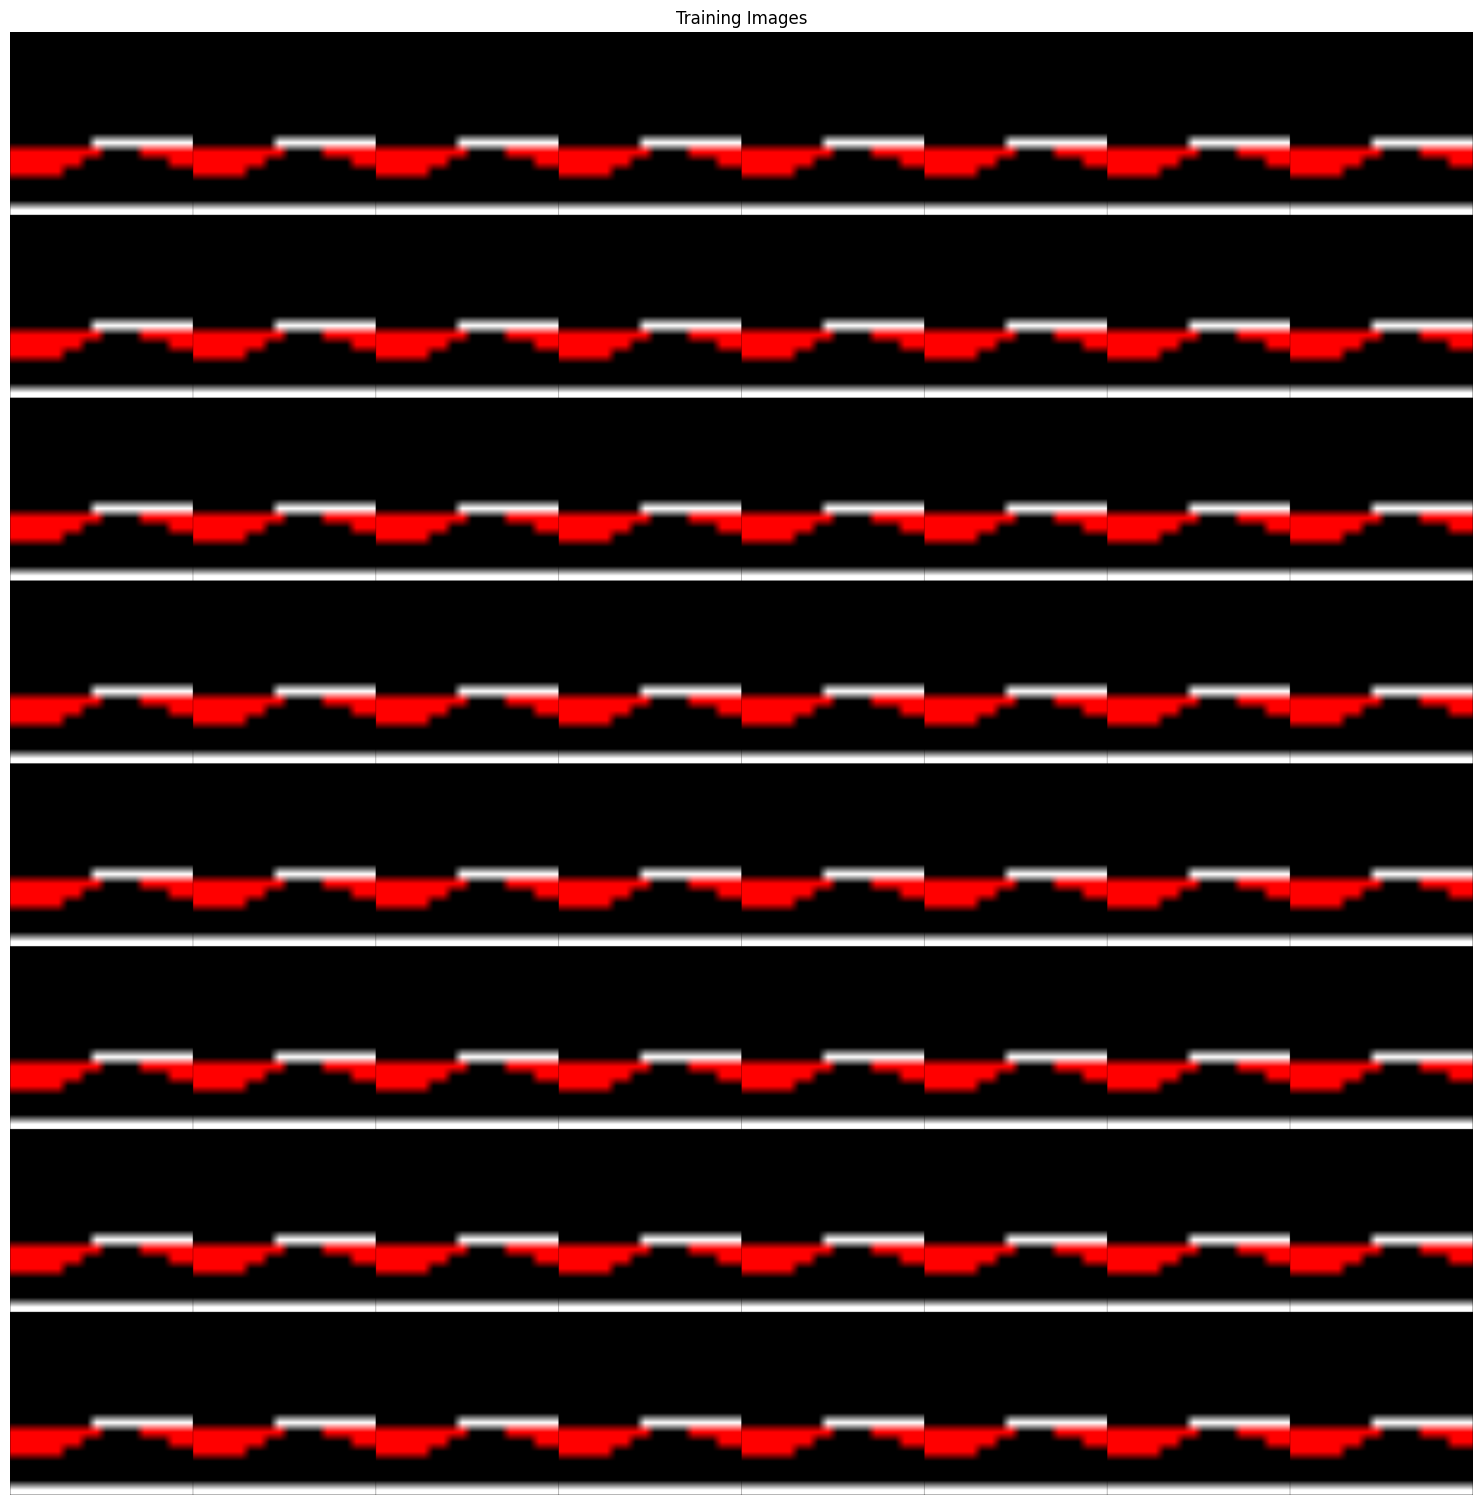

In [91]:
# データセットを作成する
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# データローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# 実行するデバイスを決定する
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# トレーニング画像をプロットする
real_batch = next(iter(dataloader))
plt.figure(figsize=(70,19))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [76]:
# G（生成器）とD（識別器）の重みの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [77]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力は Z で、畳み込み層に渡されます
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # サイズ (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # サイズ  (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # サイズ (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # サイズ (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # サイズ (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [92]:
# ジェネレーターを作成します
netG = Generator(ngpu).to(device)

# 必要に応じてGPUを使用します
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# weights_init関数を適用して、すべての重みを平均「0」、標準偏差「0.02」でランダムに初期化します。
netG.apply(weights_init)

# モデルを出力します
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [93]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力は (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [94]:
# Create the Discriminator
# 識別器を作成します
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
# 必要に応じてGPUを使用します
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# weights_init関数を適用して、すべての重みを平均「0」、標準偏差「0.02」でランダムに初期化します。
netD.apply(weights_init)

# Print the model
# モデルを出力します
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [95]:
# BCELoss関数を初期化します
criterion = nn.BCELoss()

# ジェネレータの進行を視覚化するために使用する潜在ベクトルを作成します
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# トレーニング中に本物のラベルと偽のラベルのルールを設定します
real_label = 1.
fake_label = 0.

# G と D に Adam オプティマイザを設定する
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [96]:
# トレーニングループ

# 進捗状況を追跡するためのリスト
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# エポックごとのループ
for epoch in range(num_epochs):
    # データローダーのバッチごとのループ
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Dネットワークの更新：log(D(x)) + log(1 - D(G(z))) を最大化します
        ###########################
        ## 実在の画像でトレーニングします
        netD.zero_grad()
        # バッチのフォーマット
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # 実在の写真で D の順伝播させます
        output = netD(real_cpu).view(-1)
        # 損失を計算します
        errD_real = criterion(output, label)
        # 逆伝播でDの勾配を計算します
        errD_real.backward()
        D_x = output.mean().item()

        ## 偽の画像でトレーニングします
        # 潜在ベクトルのバッチを生成します
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Gで偽の画像を生成します
        fake = netG(noise)
        label.fill_(fake_label)
        # 生成した偽画像をDで分類します
        output = netD(fake.detach()).view(-1)
        # Dの損失を計算します
        errD_fake = criterion(output, label)
        # 勾配を計算します
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 実在の画像の勾配と偽画像の勾配を加算します
        errD = errD_real + errD_fake
        # Dを更新します
        optimizerD.step()

        ############################
        # (2) Gネットワ​​ークの更新：log(D(G(z))) を最大化します
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 偽のラベルは生成器の損失にとって本物です
        # パラメータ更新後のDを利用して、偽画像を順伝播させます
        output = netD(fake).view(-1)
        # この出力に基づいてGの損失を計算します
        errG = criterion(output, label)
        # Gの勾配を計算します
        errG.backward()
        D_G_z2 = output.mean().item()
        # Gを更新します
        optimizerG.step()

        # トレーニング統計を出力します
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 後でプロットするために損失を保存します
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noiseによる G の出力を保存し、生成器の精度を確認します
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([819200])) is deprecated. Please ensure they have the same size.

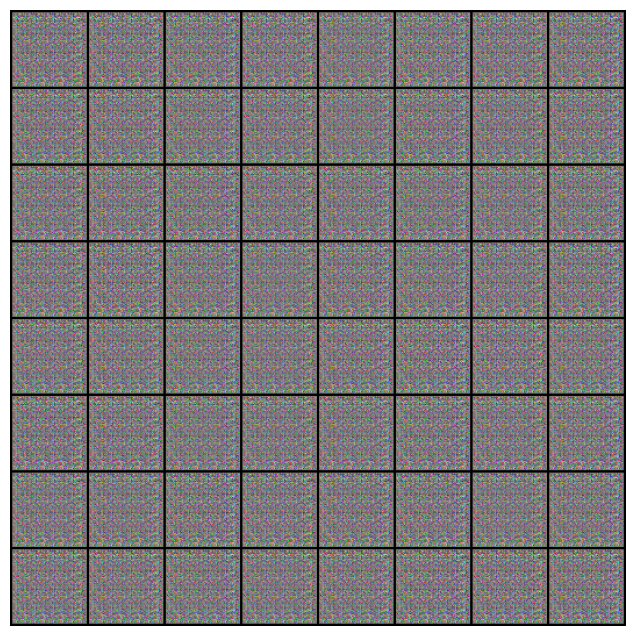

In [83]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

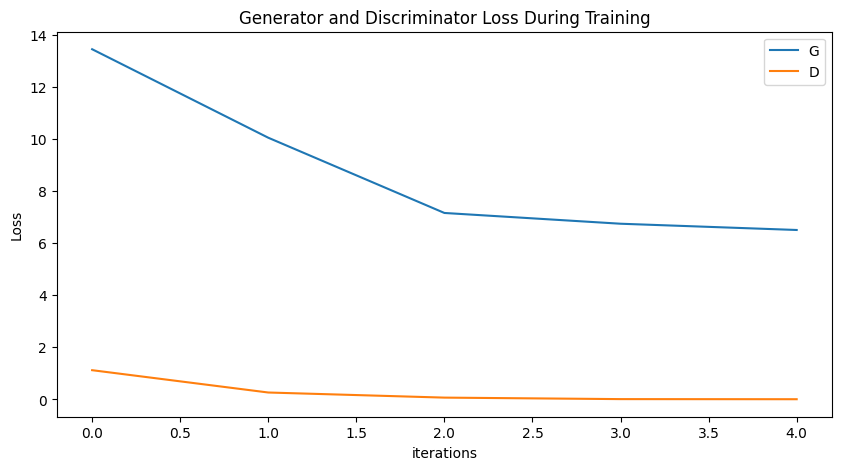

In [72]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()